In [1]:
# Leitura do CSV
import pandas as pd
import numpy as np
import spotipy
import csv
import sys
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2

In [2]:
artists = pd.read_csv('artists.csv')
data_by_artist = pd.read_csv('data_by_artist_o.csv')
data_by_genres = pd.read_csv('data_by_genres_o.csv')
data_by_year = pd.read_csv('data_by_year_o.csv')
data = pd.read_csv('data_o.csv')
tracks = pd.read_csv('tracks.csv')

In [3]:
# Getting artist that have genres
artists_with_genres = artists.copy()
artists_with_genres["has_genre"] = artists_with_genres["genres"] != "[]"
artists_with_genres.drop(artists_with_genres[artists_with_genres['has_genre'] == False].index, inplace=True)
# Getting artist that have less than 10 genres
artists_with_genres["genres_list"] = artists_with_genres["genres"].apply(eval)
artists_with_genres["multiple_genres"] = [True if (len(x) > 10) else False for x in artists_with_genres["genres_list"]]
artists_with_genres.drop(artists_with_genres[artists_with_genres['multiple_genres'] == True].index, inplace=True)
artists_with_genres["genres"] = artists_with_genres["genres"].str.replace("'", "")
artists_with_genres["genres"] = artists_with_genres["genres"].str.replace("[", "", regex = True)
artists_with_genres["genres"] = artists_with_genres["genres"].str.replace("]", "", regex = True)
artists_with_genres.head()

,id,followers,genres,name,popularity,has_genre,genres_list,multiple_genres
45,0VLMVnVbJyJ4oyZs2L3Yl2,71.0,carnaval cadiz,Las Viudas De Los Bisabuelos,6,True,[carnaval cadiz],False
46,0dt23bs4w8zx154C5xdVyl,63.0,carnaval cadiz,Los De Capuchinos,5,True,[carnaval cadiz],False
47,0pGhoB99qpEJEsBQxgaskQ,64.0,carnaval cadiz,Los “Pofesionales”,7,True,[carnaval cadiz],False
48,3HDrX2OtSuXLW5dLR85uN3,53.0,carnaval cadiz,Los Que No Paran De Rajar,6,True,[carnaval cadiz],False
136,22mLrN5fkppmuUPsHx6i2G,59.0,"classical harp, harp",Vera Dulova,3,True,"[classical harp, harp]",False


In [4]:
genres_dict = {}
for index, artist in artists_with_genres.iterrows():
  for genre in artist['genres_list']:
    if genre in genres_dict:
      genres_dict[genre]+=1
    else:
      genres_dict[genre]=1
genres_dict = sorted(genres_dict.items(), key= lambda x:x[1], reverse=True)
#print(genres_dict)

In [5]:
main_genres = {
  'classical':'orchestra[\s\S]*|\b?[\s\S]*classical[\s\S]*\b?|[\s\S]*piano[\s\S]+|opera',
  'rock':r'[\s\S]+rock[\s\S]*|[\s\S]+metal[\s\S]*|[\s\S]+punk[\s\S]*',
  'pop':r'[\s\S]+pop[\s\S]*',
  'rap':r'[\s\S]* rap[\s\S]*',
  'jazz':r'[\s\S]*jazz[\s\S]*|bossa nova',
  'reggae':r'\b[\s\S]*reggae|latin[\s\S]*',
  'folk':r"[\s\S]*folk[\s\S]*|\brebetiko|hawaiian, jawaiian|ukulele|duranguense|grupera|ranchera|[\s\S]*regional mexican|norteno",
  'country':r'[\s\S]*country[\s\S]*|\btejano\b',
  'rnb':r'[\s\S]*blues[\s\S]*|[\s\S]*r&b[\s\S]*',
  'funk':r'[\s\S]*funk[\s\S]*|[\s\S]*disco[\s\S]*|[\s\S]*hip hop[\s\S]*',
  'edm':r'electronica|[\s\S]*edm[\s\S]*|electro house|electronic trap'
}

for genre in main_genres:
  if genre == 'classical':
    artists_with_genres["genres_main"]=artists_with_genres["genres"].str.replace(main_genres[genre],genre, regex = True)
  else:
    artists_with_genres["genres_main"]=artists_with_genres["genres_main"].str.replace(main_genres[genre],genre, regex = True)

pd.set_option("display.max_rows",None)
artists_with_genres["genres_main"].value_counts().head(11)

rock         47732
pop          36476
funk         14370
classical     9901
folk          9429
jazz          9078
rap           6907
rnb           3679
reggae        2602
country       1846
edm           1474
Name: genres_main, dtype: int64

In [6]:
# Creating a dictionary which categorises an artist's work into a main genre of music

artist_dictionary={}
for index, row in artists_with_genres.iterrows():
    artist_id=row["id"]
    artist_genre=row["genres_main"]
    artist_dictionary[artist_id]=artist_genre

In [7]:
tracks_with_genres = tracks.copy()
tracks_with_genres.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [8]:
#Adding a genre column in data2 by using information in dictionary created above
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.replace("\[","", regex = True)
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.replace("\]","", regex = True)
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.replace(", ",",")
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.split(",")

def genre_according_artist(column):
    music_style=[]
    for artist in column:
        artist=artist.strip("'")
        if artist in artist_dictionary:
            #print(artist)
            music_style.append(artist_dictionary[artist])
    return music_style
            
tracks_with_genres["genre"] = tracks_with_genres["id_artists"].apply(genre_according_artist)
tracks_with_genres.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,[]
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,[]
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,"[tango, vintage tango]"
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,"[tango, vintage tango]"
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,"[adult standards, big band, easy listening, lo..."


In [9]:
tracks_with_genres["has_genre"] = [x != [] for x in tracks_with_genres["genre"]]
tracks_with_genres.drop(tracks_with_genres[tracks_with_genres['has_genre'] == False].index, inplace=True)

tracks_with_genres["genres_list"] = [len(x) > 1 for x in tracks_with_genres["genre"]]
tracks_with_genres.drop(tracks_with_genres[tracks_with_genres['genres_list'] == True].index, inplace=True)

In [10]:
tracks_with_genres['genre_string'] = [','.join(map(str, l)) for l in tracks_with_genres['genre']]

tracks_with_genres["genre_string"].value_counts().head(11)

rock         145759
pop          132463
jazz          23793
folk          13403
funk          10578
classical      9500
hoerspiel      8424
rap            5732
reggae         3764
country        2987
rnb            2759
Name: genre_string, dtype: int64

In [11]:
training_tracks = tracks_with_genres.query("genre_string in ['classical','rock','pop','rap','jazz','reggae','folk','country','rnb','funk','edm']")
training_tracks.to_csv('training_dataset.csv')

final_df = training_tracks.sort_values(by=['popularity'], ascending=False)
#training_tracks.head(50)
final_df.head(100)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,has_genre,genres_list,genre_string
93803,7lPN2DXiMsVn7XUKtOW1CS,drivers license,99,242014,1,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],2021-01-08,0.585,0.436,...,0.72100,0.000013,0.1050,0.1320,143.874,4,[pop],True,False,pop
93804,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,98,132780,0,['Masked Wolf'],['1uU7g3DNSbsu0QjSEqZtEd'],2021-01-06,0.778,0.695,...,0.17500,0.000000,0.1500,0.4720,149.996,4,[funk],True,False,funk
92811,6tDDoYIxWvMLTdKpjFkc1B,telepatía,97,160191,0,['Kali Uchis'],['1U1el3k54VvEUzo3ybLPlM'],2020-12-04,0.653,0.524,...,0.11200,0.000000,0.2030,0.5530,83.970,4,[pop],True,False,pop
92810,5QO79kh1waicV47BqGRL3g,Save Your Tears,97,215627,1,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.680,0.826,...,0.02120,0.000012,0.5430,0.6440,118.051,4,[pop],True,False,pop
92813,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,96,200040,0,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.514,0.730,...,0.00146,0.000095,0.0897,0.3340,171.005,4,[pop],True,False,pop
92816,3FAJ6O0NOHQV8Mc5Ri6ENp,Heartbreak Anniversary,94,198371,0,['Giveon'],['4fxd5Ee7UefO4CUXgwJ7IP'],2020-03-27,0.449,0.465,...,0.52400,0.000001,0.3030,0.5430,89.087,3,[rnb],True,False,rnb
91866,60ynsPSSKe6O3sfwRnIBRf,Streets,94,226987,1,['Doja Cat'],['5cj0lLjcoR7YOSnhnX0Po5'],2019-11-07,0.749,0.463,...,0.20800,0.037100,0.3370,0.1900,90.028,4,[pop],True,False,pop
92817,27OeeYzk6klgBh83TSvGMA,WITHOUT YOU,94,161385,1,['The Kid LAROI'],['2tIP7SsRs7vjIcLrU85W8J'],2020-11-06,0.662,0.413,...,0.21300,0.000000,0.1340,0.4670,93.005,4,[funk],True,False,funk
93807,4cG7HUWYHBV6R6tHn1gxrl,Friday (feat. Mufasa & Hypeman) - Dopamine Re-...,94,169153,0,"['Riton', 'Nightcrawlers', 'Mufasa & Hypeman',...","['7i9j813KFoSBMldGqlh2Z1', '1gALaWbNDnwS2ECV09...",2021-01-15,0.824,0.862,...,0.00760,0.000132,0.3030,0.8010,122.980,4,[pop],True,False,pop
92823,3YJJjQPAbDT7mGpX3WtQ9A,Good Days,93,279204,1,['SZA'],['7tYKF4w9nC0nq9CsPZTHyP'],2020-12-25,0.436,0.655,...,0.49900,0.000008,0.6880,0.4120,121.002,4,[pop],True,False,pop


In [12]:
training_tracks.dtypes

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit              int64
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
genre                object
has_genre              bool
genres_list            bool
genre_string         object
dtype: object

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [14]:
from fast_ml.model_development import train_valid_test_split

In [81]:
X = training_tracks.copy().dropna()
filtro = X['popularity'] > 0
X = X[filtro]
X = X[['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms' ,'popularity']]
X['popularity'].min()

1

In [82]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, target = 'popularity', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

In [83]:
X_train.head()

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms
171868,0.651,0.697,8,-6.797,0,0.0312,0.689000,0.2510,0.690,110.129,265867
88138,0.497,0.475,7,-12.649,1,0.0422,0.405000,0.3540,0.625,147.611,616800
41247,0.372,0.753,0,-12.430,1,0.4930,0.000085,0.1760,0.752,204.005,142693
37055,0.486,0.186,5,-13.335,1,0.0422,0.000000,0.1350,0.469,135.339,176560
333983,0.507,0.959,11,-5.102,1,0.1240,0.004470,0.0712,0.643,156.608,163000


In [84]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']

In [85]:
preprocessor = make_column_transformer(
    (MinMaxScaler(), features_num)
)

In [86]:
preprocessor_y = make_column_transformer(
    (MinMaxScaler(),['popularity'])
)

In [87]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100
y_test = y_test / 100
X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [11]


In [88]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001,
                                        patience= 5,
                                        restore_best_weights=True)

Epoch 1/100
4267/4267 [==============================] - 8s 2ms/step - loss: 0.1588 - accuracy: 0.0000e+00 - val_loss: 0.1313 - val_accuracy: 0.0000e+00
Epoch 2/100
4267/4267 [==============================] - 7s 2ms/step - loss: 0.1333 - accuracy: 0.0000e+00 - val_loss: 0.1295 - val_accuracy: 0.0000e+00
Epoch 3/100
4267/4267 [==============================] - 7s 2ms/step - loss: 0.1313 - accuracy: 0.0000e+00 - val_loss: 0.1279 - val_accuracy: 0.0000e+00
Epoch 4/100
4267/4267 [==============================] - 7s 2ms/step - loss: 0.1301 - accuracy: 0.0000e+00 - val_loss: 0.1271 - val_accuracy: 0.0000e+00
Epoch 5/100
4267/4267 [==============================] - 7s 2ms/step - loss: 0.1294 - accuracy: 0.0000e+00 - val_loss: 0.1268 - val_accuracy: 0.0000e+00
Epoch 6/100
4267/4267 [==============================] - 7s 2ms/step - loss: 0.1288 - accuracy: 0.0000e+00 - val_loss: 0.1265 - val_accuracy: 0.0000e+00
Epoch 7/100
4267/4267 [==============================] - 7s 2ms/step - loss: 0.128

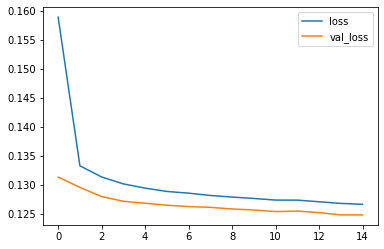

In [89]:
model = keras.Sequential([
    layers.Dense(45, activation='relu', input_shape=input_shape),
    layers.Dropout(0.15),
    layers.BatchNormalization(),
    layers.Dense(23, activation='relu'),
    layers.Dropout(0.15),
    layers.BatchNormalization(),
    layers.Dense(9, activation='relu'),
    layers.Dropout(0.15),
    layers.BatchNormalization(),
    layers.Dense(1, activation = 'sigmoid')
    
])
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics='accuracy'
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [92]:
resultado = model.predict(X_test)
resultado = resultado * 100
esperado = y_test * 100

teste = pd.DataFrame(resultado,esperado)
teste.head(300)

1067/1067 [==============================] - 1s 841us/step


,0
popularity,
13.0,23.571077
39.0,35.359638
31.0,42.925835
15.0,30.305660
2.0,17.647928
40.0,26.198254
23.0,33.237919
42.0,28.517574
36.0,30.344032


In [93]:
client_id = 'ddf5739029b0474587bc3f845f7220a0'
client_secret = '83758fd8a9974ea0ae9e3689e9803c8e'

In [94]:
username ='12166356598'
scope = 'playlist-read-private'
redirect_uri = 'http://localhost:9001/callback'
playlist = '2ISRFOh87p6vEnCfj2EKpa'


token = util.prompt_for_user_token(username,
                                   scope,
                                   client_id,   
                                   client_secret,     
                                   redirect_uri)

In [95]:
def analyze_playlist(creator, playlist_id):
    
    # Create empty dataframe
    playlist_features_list = ["artist","album","track_name",  "track_id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Loop through every track in the playlist, extract features and append the features to the playlist df
    
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        # Create empty dict
        playlist_features = {}
        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        
        # Get audio features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

In [96]:
if token:
    sp = spotipy.Spotify(auth = token)  
    playlist = analyze_playlist(username,playlist)
playlist

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Post Malone,Hollywood's Bleeding,Circles,21jGcNKet2qwijlDFuPiPb,0.695,0.762,0,-3.497,1,0.0395,0.002440,0.0863,0.5530,120.042,215280,4
1,Vitão,Complicado,Complicado,52vPpP2gEYaBROIS77J38P,0.734,0.484,7,-7.486,0,0.1300,0.000000,0.2240,0.4990,130.050,179339,4
2,Post Malone,Hollywood's Bleeding,Goodbyes (feat. Young Thug),0t3ZvGKlmYmVsDzBJAXK8C,0.548,0.653,5,-3.875,1,0.0810,0.000000,0.1030,0.1630,150.068,174853,4
3,Gusttavo Lima,O Embaixador in Cariri (Ao Vivo),A Gente Fez Amor - Ao Vivo,3tv697PZNnaQN0Mn2zGhS5,0.794,0.937,8,-2.440,0,0.0336,0.000004,0.9620,0.8260,134.012,237517,4
4,Luan Santana,VIVA (Ao Vivo),choque térmico - ao vivo,159ntSAEWJ9zIMOSXmQ530,0.737,0.758,2,-5.508,1,0.0402,0.000000,0.8340,0.7340,126.978,180001,4
5,Marília Mendonça,Graveto (Ao Vivo),Graveto - Ao Vivo,3tc8Z4lGzOIwmIVftsxO6o,0.714,0.632,9,-5.100,1,0.0312,0.000000,0.8120,0.4020,93.052,170877,4
6,Gustavo Mioto,Plaquinha de Aviso (Ao Vivo),Plaquinha de Aviso - Ao Vivo,2vdY4HzOTDkgHPlzgOVsdE,0.589,0.915,9,-2.663,0,0.2340,0.000000,0.7580,0.6340,134.989,185205,4
7,Avine Vinny,Maturidade (feat. Matheus & Kauan),Maturidade (feat. Matheus & Kauan),3QkKCTSHnJlUag0GG9F1cN,0.604,0.726,7,-8.577,0,0.0494,0.000000,0.9050,0.7820,148.007,194240,4
8,Alok,Vale Vale,Vale Vale,3bTjd1iQJvsfIoH8v7A0Gy,0.475,0.896,1,-5.696,0,0.0765,0.073400,0.4290,0.3050,133.998,193433,4
9,Post Malone,Hollywood's Bleeding,Wow.,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,11,-7.359,0,0.2080,0.000002,0.1030,0.3880,99.960,149547,4


In [97]:
playlist = playlist.drop(['time_signature'], axis = 'columns')

In [98]:
new_X = playlist[['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']]

new_X['key'] = new_X['key'].astype(float)
new_X['mode'] = new_X['mode'].astype(float)
new_X['duration_ms'] = new_X['duration_ms'].astype(float)
new_X.dtypes

danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms         float64
dtype: object

In [99]:
scaler = MinMaxScaler()

# Fit the scaler to the data
scaler.fit(new_X)

# Transform the data to the scaled range
df = scaler.transform(new_X)

In [100]:
predictions = model.predict(df)
predictions = predictions * 100

3/3 [==============================] - 0s 2ms/step


In [102]:
playlist['predictions'] = predictions

print(playlist[['track_name','predictions']])

                                           track_name  predictions
0                                             Circles    33.245132
1                                          Complicado    25.052305
2                         Goodbyes (feat. Young Thug)    34.817135
3                          A Gente Fez Amor - Ao Vivo    33.406593
4                            choque térmico - ao vivo    29.496586
5                                   Graveto - Ao Vivo    30.180931
6                        Plaquinha de Aviso - Ao Vivo    32.322201
7                  Maturidade (feat. Matheus & Kauan)    24.053616
8                                           Vale Vale    30.102316
9                                                Wow.    38.445473
10                     Liberdade Provisória - Ao Vivo    24.053951
11           SOFRENDO FEITO UM LOUCO - SUMMER VERSION    25.348061
12                                       S de Saudade    28.387972
13                                         Intentions    24.66